In [1]:
# a demonstration of use of the logistic regression classifier 
# for content classification on doc2vec docs vectors
# where logit probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
# [3] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]
# product_list = ["amq", "webserver", "datagrid"]

In [3]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 20)
# d2v_wrapper.infer_content_vectors()
# d2v_wrapper.persist_trained_wrapper(model_save_path="trained_models/wrapper/10epoch_train_stem_not_removed_header")

# TODO: gets the best performance for Logistic Regression
# TODO: train again: d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/5epoch_train_stem_not_removed_header_v800")

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header")

2017-05-10 15:29:34,405 : INFO : Loading serialized wrapper model from: trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header
2017-05-10 15:29:34,406 : INFO : Loading all_base_vocab_docs objects
2017-05-10 15:29:42,980 : INFO : Initialized 43478 headers of 43478 for vectorization
2017-05-10 15:29:42,981 : INFO : Loading all_base_vocab_docs vectors
2017-05-10 15:30:21,252 : INFO : Loading trained Doc2Vec model
2017-05-10 15:30:21,252 : INFO : loading Doc2Vec object from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod
2017-05-10 15:30:21,509 : INFO : loading docvecs recursively from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.* with mmap=None
2017-05-10 15:30:21,510 : INFO : loading doctag_syn0 from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-05-10 15:30:21,537 : INFO : loading syn1neg from trained_model

In [4]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_vocab_content_vectors()
# TODO: below func merged to d2v_wrapper, remove for newer model checkpoints
doc_vectors_labeled.columns = np.arange(len(doc_vectors_labeled.columns[:-1])).tolist()+["y"]
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-05-10 15:30:21,635 : INFO : Returning already inferred doc vectors of 43478 all_base_vocab_docs


In [5]:
doc_vectors_labeled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,y
0,-0.261148,-0.143183,0.206254,0.002638,-0.136853,-0.184459,0.400641,-0.026630,0.055222,-0.507141,...,-0.002771,0.193008,-0.061081,0.116081,0.053434,0.050748,0.061903,-0.013674,-0.081310,amq
1,0.129629,0.330915,0.078725,0.343039,-0.164130,-0.322203,0.089643,-0.096555,-0.143530,0.177542,...,-0.036439,0.098115,-0.047751,0.191983,0.103851,-0.014857,0.147300,-0.048710,0.028055,amq
2,-0.122895,0.042616,0.311727,0.068287,-0.190215,-0.286972,-0.030751,-0.023960,-0.217911,0.005918,...,-0.034230,0.203534,0.057952,0.132727,0.011877,-0.031473,0.093483,-0.105260,-0.107189,amq
3,-0.081051,-0.112118,0.157368,0.018006,-0.024450,-0.293881,-0.078382,-0.241100,0.103017,0.140719,...,0.023935,0.223113,-0.047766,0.126704,0.071557,-0.091953,0.223931,-0.076425,0.104130,amq
4,-0.248997,-0.072568,0.270651,0.378066,0.100578,0.104005,0.063351,0.003771,0.149455,0.300134,...,0.020857,0.122567,0.028789,0.043602,-0.046213,-0.016964,0.118787,-0.025481,-0.185460,amq
5,0.132138,-0.070874,0.411625,-0.073018,-0.201902,0.128727,-0.243356,-0.355984,0.040756,-0.311196,...,-0.045529,0.303851,0.028779,0.072786,-0.054523,-0.022502,0.141018,-0.041490,0.015366,amq
6,0.415581,0.094154,0.334570,-0.033714,0.001877,-0.015157,0.087919,-0.355922,0.082679,0.082770,...,-0.023633,0.257899,0.042370,0.109216,0.000828,-0.008879,0.222199,-0.005134,-0.033780,amq
7,0.672777,-0.549360,0.014788,0.015485,-0.034586,-0.177955,-0.117172,-0.534560,-0.230965,-0.185388,...,-0.071189,0.291642,-0.042231,0.106547,-0.054053,-0.031451,0.192578,-0.021674,-0.050568,amq
8,-0.231420,0.146912,0.162502,0.121931,-0.277280,-0.140563,0.052438,-0.346920,0.122520,0.111098,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq
9,0.087633,0.331549,0.233062,-0.045076,-0.174967,-0.079236,0.206668,-0.217895,-0.059720,-0.198520,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq


In [6]:
# limit the content to specific categories
# limit_prod_list = ["webserver", "datagrid", "fuse", "brms"]
# doc_vectors = doc_vectors[doc_labels.isin(limit_prod_list)]
# doc_labels = doc_labels[doc_labels.isin(limit_prod_list)]
# doc_vectors.describe()

In [7]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [8]:
# classifier training and eval:
from sklearn.linear_model import LogisticRegression

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    # training
    logging.info("Fitting classifier")
    log_reg_classifier = LogisticRegression(C=0.3, solver="sag", multi_class='ovr', n_jobs=8, max_iter=1000)
    log_reg_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])
    
    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = log_reg_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(log_reg_classifier.classes_)
    
    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)),(class_actual_index)]
    
    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)),(class_expected_index)]
    
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)
    
    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

2017-05-10 15:30:21,954 : INFO : Fitting classifier
2017-05-10 15:33:29,541 : INFO : Predicting
2017-05-10 15:33:29,885 : INFO : Probs collection
2017-05-10 15:33:30,243 : INFO : Split results:
2017-05-10 15:33:30,249 : INFO : Run accuracy: 0.869800045966
2017-05-10 15:33:30,255 : INFO : Cat accuracies:
[0.366412213740458, 0.9505599562960939, 0.3020833333333333, 0.3492063492063492, 0.8771686328938237, 0.4485294117647059, 0.5466666666666666, 0.8237037037037037, 0.13333333333333333, 0.0, 0.955487336914812, 0.0, 0.3333333333333333, 0.9184549356223176]
2017-05-10 15:33:30,276 : INFO : Fitting classifier
2017-05-10 15:36:40,219 : INFO : Predicting
2017-05-10 15:36:40,554 : INFO : Probs collection
2017-05-10 15:36:40,898 : INFO : Split results:
2017-05-10 15:36:40,904 : INFO : Run accuracy: 0.868260719623
2017-05-10 15:36:40,910 : INFO : Cat accuracies:
[0.4198473282442748, 0.9505599562960939, 0.2670157068062827, 0.36507936507936506, 0.8549618320610687, 0.4411764705882353, 0.5822222222222222

In [10]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-05-10 15:45:51,719 : INFO : split accuracies: [0.86980004596644445, 0.86826071962294515, 0.87153536515238639, 0.86965025310630462, 0.87111622554660528]
2017-05-10 15:45:51,720 : INFO : mean accuracy: 0.870072521879
2017-05-10 15:45:51,730 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.366412  0.950560   0.302083  0.349206  0.877169  0.448529  0.546667   
0  0.419847  0.950560   0.267016  0.365079  0.854962  0.441176  0.582222   
0  0.412214  0.943443   0.267016  0.380952  0.876475  0.533088  0.520000   
0  0.419847  0.952186   0.382199  0.444444  0.862595  0.424354  0.531250   
0  0.400000  0.945355   0.324607  0.370968  0.879944  0.468635  0.544643   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.823704  0.133333               0.0  0.955487                  0.0   
0   0.834074  0.000000               0.0  0.957757                  0.0   
0   0.826667  0.214286               0.0 

In [11]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.112381,72
12,mobileplatform,0.386667,101
3,datagrid,0.382130,314
0,amq,0.403664,654
2,webserver,0.308584,956
6,bpmsuite,0.544956,1123
5,brms,0.463157,1358
7,devstudio,0.827749,3373


In [12]:
labels_size["size"].describe()

count       14.000000
mean      3105.571429
std       4979.779138
min          5.000000
25%        154.250000
50%       1039.500000
75%       3462.250000
max      18302.000000
Name: size, dtype: float64

In [13]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
27030,fuse,0.647036,fuse,0.647036
33840,rhel,0.983799,rhel,0.983799
42823,openshift,0.874549,openshift,0.874549
7004,eap,0.883637,eap,0.883637
15570,eap,0.957493,eap,0.957493
24448,fuse,0.972849,fuse,0.972849
22123,fuse,0.857691,fuse,0.857691
11206,eap,0.967170,eap,0.967170
30850,devstudio,0.924652,devstudio,0.924652


In [14]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['fuse', 'rhel', 'openshift', 'eap', 'devstudio', 'brms'], dtype=object)

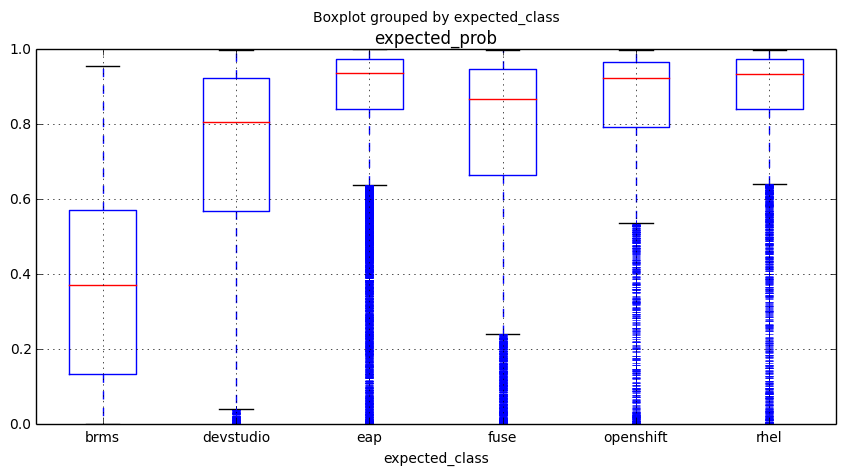

In [15]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [16]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count    5649.000000
mean      124.080014
std       367.629615
min        10.000000
25%        18.000000
50%        32.000000
75%        73.000000
max      7889.000000
Name: doc_id, dtype: float64

In [17]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    37829.000000
mean       139.332708
std        633.941251
min         10.000000
25%         26.000000
50%         41.000000
75%        105.000000
max      79212.000000
dtype: float64

In [21]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True))).values
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                d2v_wrapper.get_doc_content(int(doc_id), word_split=False)).values

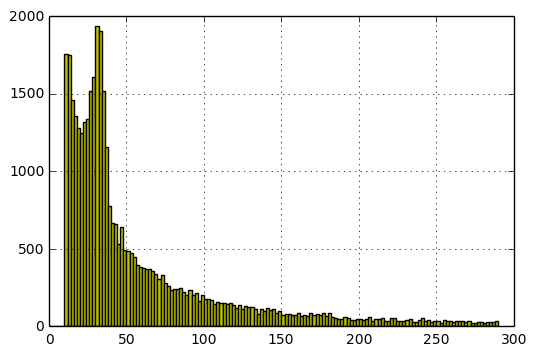

In [23]:
# all docs length distribution
%matplotlib inline
bordering_q = 0.9
plot_data = logits["content_len"]
bordering_q_value = int(plot_data.quantile(q=bordering_q))
plt.hist(plot_data, bins=(bordering_q_value+1)/2, range=(0, bordering_q_value), color="y")
plt.gca().set_axis_bgcolor('white')
plt.grid()
plt.show()

In [24]:
plot_data.describe()

count    43478.000000
mean       137.350959
std        606.010124
min         10.000000
25%         25.000000
50%         39.000000
75%        100.000000
max      79212.000000
Name: content_len, dtype: float64

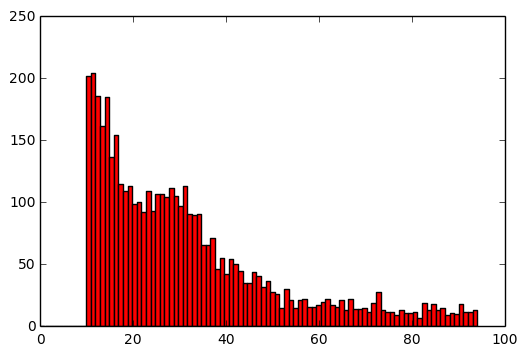

In [25]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

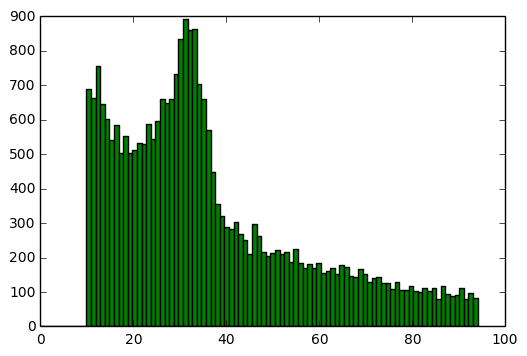

In [26]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 94 artists>

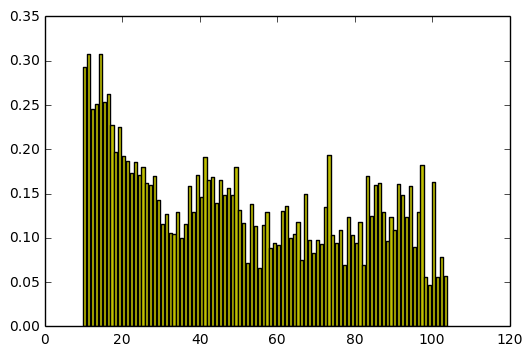

In [27]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

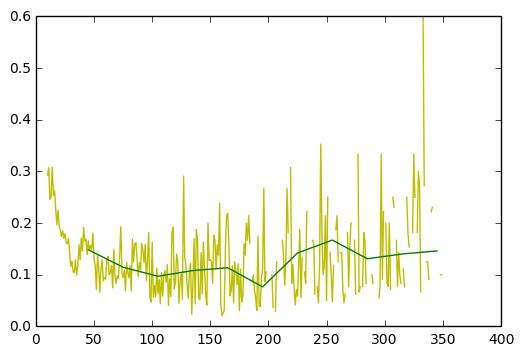

In [28]:
error_plot_border = 350
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")

mean_range = 30
mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [29]:
# above: rolling/moving average

In [30]:
# correctly classified docs with its content
logits[logits["actual_class"] != logits["expected_class"]][:30]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
27693,eap,0.756046,brms,0.109622,12,red hat jboss enterprise application platform ...
624,fuse,0.854322,amq,0.123550,47,problem seen osgi version websphere client run...
20658,rhel,0.937843,fuse,0.010437,314,kernel packages contain linux kernel core linu...
24321,amq,0.515619,fuse,0.466025,49,current amq broker running paris master slave ...
9505,webserver,0.776045,eap,0.003628,15,supported mod cluster binaries available red h...
31899,eap,0.552959,devstudio,0.000995,24,sir having information jboss devlpment want kn...
36630,eap,0.473253,rhel,0.358900,25,recently internet search engines announced pre...
516,fuse,0.578401,amq,0.359645,10,user reading documentation unable resource ada...
2081,fuse,0.507504,eap,0.025072,51,developer bpm suite learn maven repositories r...


In [31]:
# misclassified docs with its content 
content_array = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10]["content"].values
content_index = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)
# print d2v_wrapper.get_doc_content(doc_id, word_split=False)

27693: red hat jboss enterprise application platform eap jboss enterprise web server ews.

624: problem seen osgi version websphere client runtime fuse camel route communicates fails start following message seen fuse log caused java lang exception unable convert value com ibm jms mqconnectionfactory type javax jms connectionfactory org apache aries blueprint container aggregateconverter convert aggregateconverter java org apache aries blueprint core.

20658: kernel packages contain linux kernel core linux operating flaw way linux kernel transparent huge pages thp implementation handled non huge page migration local unprivileged user use flaw crash kernel migrating transparent hugepages cve moderate buffer overflow flaw way linux kernel ecryptfs implementation decoded encrypted file names local unprivileged user use flaw crash potentially escalate privileges cve moderate race condition flaw chown execve calls changing owner setuid user binary root race condition momentarily binary setui

In [32]:
act_cdk = logits[logits["actual_class"] == "cdk"]
act_cdk[act_cdk["expected_class"] == "cdk"]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
33309,cdk,0.315557,cdk,0.315557,37,red hat development suite red hat development ...
33325,cdk,0.550842,cdk,0.550842,64,red hat container development kit platform dev...
33298,cdk,0.471009,cdk,0.471009,35,prepare mac development running container deve...
33304,cdk,0.544665,cdk,0.544665,37,prepare microsoft windows development run cont...
33333,cdk,0.655625,cdk,0.655625,78,attempting kick openshift tires cdk work natur...
33322,cdk,0.748485,cdk,0.748485,73,red hat container development kit platform dev...
33324,cdk,0.445583,cdk,0.445583,81,red hat container development kit platform dev...
33341,cdk,0.454477,cdk,0.454477,23,vmware version vagrant box red hat enterprise ...


In [ ]:
# correctly classified content
# content_array = logits[logits["actual_class"] == "cdk"]["content"].values
# content_index = logits[logits["actual_class"] == "cdk"].iloc[:10].index.values
# content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
# print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)